<a href="https://colab.research.google.com/github/Tyler-Hattori/fretboard_ai/blob/fourth/fretboard_ai_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import

In [53]:
import numpy as np
from numpy import random
from numpy.linalg import inv
from IPython.display import Audio, display
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import torch
from torch import nn
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import MultiHeadAttention, LayerNormalization, Layer, Dense, Dropout, Flatten, Embedding, Add
import os
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
drive_path = '/content/drive/My Drive/Colab/'
num_tones = 48
Fs = 44100
dur = 1 # second
num_samples = Fs * dur
batch_size = 32
scale = ['E','F','F#','G','G#','A','A#','B','C','C#','D','D#']
tones = [scale[np.mod(i,len(scale))] for i in range(num_tones)]

### seq2key model

In [12]:
N = 4
D = 512
H = 8
L = 6
dff = D*4
batch_size = 32
s2k_epochs = 20
s2k_vocab_length = 150
s2k_output_dim = 12
dropout_rate = 0.1

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class S2KPositionalEmbedding(Layer):
  def __init__(self, vocab_size=s2k_vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

class S2KBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class S2KGlobalSelfAttention(S2KBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

class S2KFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class S2KEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = S2KGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = S2KFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

class Seq2Key(tf.keras.Model):
    def __init__(self, *, output_dim=s2k_output_dim, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = S2KPositionalEmbedding()
        self.encoder_layers = [S2KEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, 6*N) where None refers to batch size
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        pred = self.mlp_head(x) # (None, 12)

        pred = tf.nn.softmax(pred)

        return pred

# initialize seq2key object
s2k = Seq2Key()
s2k.load_weights(drive_path + 'seq2key')

### tab2chord model

In [13]:
N = 6 # guitar tab input
D = 512
H = 8
L = 6
dff = D*4
batch_size = 32
t2c_vocab_length = 25
t2c_output_dim = 15 # csf output
mute_string_prob = 0.05
dropout_rate = 0.1
mute_token = 0

def chord2tab(chord,mute_prob=mute_string_prob):
  m = mute_token
  tab = [m for i in range(6)]
  color = chord[0]
  shape = chord[1]
  fret = chord[2]

  if color == 0: # major chords
    if shape == 0: tab = [m,4,3,1,2,1]
    elif shape == 1: tab = [m,1,3,3,3,1]
    elif shape == 2: tab = [4,3,1,1,4,4]
    elif shape == 3: tab = [1,3,3,2,1,1]
    elif shape == 4: tab = [m,m,1,3,4,3]
  elif color == 1: # minor chords
    if shape == 0: tab = [m,4,2,1,2,m]
    elif shape == 1: tab = [m,1,3,3,2,1]
    elif shape == 2: tab = [4,2,1,1,4,4]
    elif shape == 3: tab = [1,3,3,1,1,1]
    elif shape == 4: tab = [m,m,1,3,4,2]

  tab = [tab[i] if random.rand() > mute_prob else m for i in range(6)]

  return [tab[i] + fret if tab[i] != m else m for i in range(6)]

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class T2CPositionalEmbedding(Layer):
  def __init__(self, vocab_size=t2c_vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

class T2CBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class T2CGlobalSelfAttention(T2CBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

class T2CFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class T2CEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = T2CGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = T2CFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

class Tab2Chord(tf.keras.Model):
    def __init__(self, *, output_dim=t2c_output_dim, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = T2CPositionalEmbedding()
        self.encoder_layers = [T2CEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head1 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head2 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head3 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        c = tf.nn.softmax(self.mlp_head1(x)) # (None, number of frets)
        s = tf.nn.softmax(self.mlp_head2(x)) # (None, number of frets)
        f = tf.nn.softmax(self.mlp_head3(x)) # (None, number of frets)

        # consolidate csf outputs
        y = []
        for i in range(batch_size):
          y.append([c[i], s[i], f[i]])
        out = tf.stack(y)

        return out

# initialize tab2chord object
t2c = Tab2Chord()
t2c.load_weights('/content/drive/My Drive/Colab/tab2chord')

### tones2tab model

In [14]:
T = 48
Q = 8 # T/Q should be an integer
N = int(T/Q)
D = 64
dff = 4*D
H = 8
L = 6
dropout_rate = 0.1
batch_size = 32
t2t_vocab_length = pow(2,Q)
t2t_output_dim = 25
t2t_mute_prob = 0.05
t2t_epochs = 10
A = 440 # Hz
guitar = [[A*pow(2,(-29+i)/12) for i in range(24)],
          [A*pow(2,(-24+i)/12) for i in range(24)],
          [A*pow(2,(-19+i)/12) for i in range(24)],
          [A*pow(2,(-14+i)/12) for i in range(24)],
          [A*pow(2,(-9+i)/12) for i in range(24)],
          [A*pow(2,(-5+i)/12) for i in range(24)]]

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class T2TPositionalEmbedding(Layer):
  def __init__(self, vocab_size=t2t_vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

class T2TBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class T2TGlobalSelfAttention(T2TBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

class T2TFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class T2TEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = T2TGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = T2TFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

class Tones2Tab(tf.keras.Model):
    def __init__(self, *, output_dim=t2t_output_dim, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = T2TPositionalEmbedding()
        self.encoder_layers = [T2TEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head1 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head2 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head3 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head4 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head5 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head6 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        s1 = tf.nn.softmax(self.mlp_head1(x)) # (None, number of frets)
        s2 = tf.nn.softmax(self.mlp_head2(x)) # (None, number of frets)
        s3 = tf.nn.softmax(self.mlp_head3(x)) # (None, number of frets)
        s4 = tf.nn.softmax(self.mlp_head4(x)) # (None, number of frets)
        s5 = tf.nn.softmax(self.mlp_head5(x)) # (None, number of frets)
        s6 = tf.nn.softmax(self.mlp_head6(x)) # (None, number of frets)

        # consolidate csf outputs
        y = []
        for i in range(batch_size):
          y.append([s1[i],s2[i],s3[i],s4[i],s5[i],s6[i]])
        out = tf.stack(y)

        return out

# initialize seq2key object
t2t = Tones2Tab()
t2t.load_weights('/content/drive/My Drive/Colab/tones2tab')

### audio2tones estimation

In [95]:
def audio2tones(file_name, B, chord_size, N=num_samples, tokenize=False):
  input_data = read(file_name)
  audio = input_data[1]

  # remove a channel
  audio = [audio[i][0] for i in range(len(audio))]

  # Linear Least Squares Estimation
  y = B @ audio[0:N]

  # convert spectrum to power and normalize
  y = np.abs(y)**2 / N
  data = np.real(y)
  data = data / np.max(data)
  raw = data.copy()

  # find the highest magnitude tones. chord_size denotes the number of tones used
  chord = np.zeros(chord_size,int)
  for i in range(chord_size):
    chord[i] = np.argmax(data)
    data[chord[i]] = 0

  # populate output tone vector with the tones in chord
  tones = np.zeros(num_tones,int)
  for i in range(chord_size): tones[chord[i]] = 1

  # convert to tokens if the inputs are used as inputs to a model
  if tokenize == True: tones = tones2tokens(tones)

  return tones, raw

### conversion functions

In [16]:
def seq2key(seq,model=s2k):
  input = [name2token(name,0) for name in seq]
  input = tf.convert_to_tensor([input for i in range(32)], dtype=tf.int32)
  soft = model(input)[0]
  key_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm']
  return key_names[np.argmax(soft)]

In [17]:
def chord2token(chord):
  return chord[0]*5*15 + chord[1]*15 + chord[2] + 1

In [18]:
def chord2name(chord):
  estring = ['E','F','F#','G','G#','A','A#','B','C','C#','D','D#','E','F','F#','G','A','A#']
  astring = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#','A','A#','B','C','C#','D']
  dstring = ['D','D#','E','F','F#','G','G#','A','A#','B','C','C#','D','D#','E','F','F#','G']
  name = ''
  color = chord[0]
  shape = chord[1]
  bar = chord[2]
  if shape == 0: name = name + astring[bar+3]
  elif shape == 1: name = name + astring[bar]
  elif shape == 2: name = name + estring[bar+3]
  elif shape == 3: name = name + estring[bar]
  elif shape == 4: name = name + dstring[bar]
  if color == 1: name = name + 'm'
  return name

In [19]:
def name2token(name,fret=0):
  key_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm']
  key_index = key_names.index(name)
  chord = [int(key_index > 11), -1, fret]

  diff1 = np.mod(key_index,12) - fret
  diff2 = np.mod(key_index+3,12) - fret
  diff3 = np.mod(key_index+5,12) - fret
  diff4 = np.mod(key_index+8,12) - fret
  diff5 = np.mod(key_index+10,12) - fret

  low = min(abs(diff1),abs(diff2),abs(diff3),abs(diff4),abs(diff5))
  if low == diff1: chord[1] = 0; chord[2] = diff1 + fret
  elif low == diff2: chord[1] = 1; chord[2] = diff2 + fret
  elif low == diff3: chord[1] = 2; chord[2] = diff3 + fret
  elif low == diff4: chord[1] = 3; chord[2] = diff4 + fret
  else: chord[1] = 4; chord[2] = diff5 + fret

  return chord2token(chord)

In [20]:
def token2chord(token):
  token = token - 1
  t1 = int(token/(5*15))
  t2 = int((token-(t1*5*15))/15)
  t3 = token - t1*5*15 - t2*15
  return [t1,t2,t3]

In [21]:
def chord2tab(chord,mute_prob=0,mute_token=0,data=False):
  m = mute_token
  tab = [m for i in range(6)]
  color = chord[0]
  shape = chord[1]
  fret = chord[2]

  if color == 0: # major chords
    if shape == 0: tab = [m,4,3,1,2,1]
    elif shape == 1: tab = [m,1,3,3,3,1]
    elif shape == 2: tab = [4,3,1,1,4,4]
    elif shape == 3: tab = [1,3,3,2,1,1]
    elif shape == 4: tab = [m,m,1,3,4,3]
  elif color == 1: # minor chords
    if shape == 0: tab = [m,4,2,1,2,m]
    elif shape == 1: tab = [m,1,3,3,2,1]
    elif shape == 2: tab = [4,2,1,1,4,4]
    elif shape == 3: tab = [1,3,3,1,1,1]
    elif shape == 4: tab = [m,m,1,3,4,2]

  if data == False: tab = [tab[i]-1 for i in range(len(tab))]

  tab = [tab[i] if random.rand() > mute_prob else m for i in range(6)]

  return [tab[i] + fret if tab[i] != m else m for i in range(6)]

In [22]:
def seq2tab(seq,fret=0,data=False):
  tab = []
  for i in range(len(seq)):
    tab.append(chord2tab(token2chord(name2token(seq[i],fret)),data=data))
  return tab

In [23]:
def tab2seq(tab,t2c_model=t2c):
  seq = []
  for i in range(len(tab)):
    csf = t2c_model(tf.convert_to_tensor([tab[i] for j in range(batch_size)], tf.int32))
    c = int(tf.math.argmax(csf[0][0]))
    s = int(tf.math.argmax(csf[0][1]))
    f = int(tf.math.argmax(csf[0][2]))
    token = chord2token([c,s,f])
    seq.append(token)
  return tf.stack(seq)

In [24]:
def tab2chord(tab,model=t2c):
  input = tf.convert_to_tensor([tab[np.mod(i,len(tab))] for i in range(32)], dtype=tf.int32)
  soft = model(input)[:len(tab)]
  output = []
  for i in range(len(tab)):
    output.append(chord2name([int(tf.math.argmax(soft[i][0])),int(tf.math.argmax(soft[i][1])),int(tf.math.argmax(soft[i][2]))]))
  return output

In [25]:
def tab2key(tab,model=t2c):
  input = tf.convert_to_tensor([tab[np.mod(i,len(tab))] for i in range(32)], dtype=tf.int32)
  soft = model(input)[:len(tab)]
  output = []
  for i in range(len(tab)):
    output.append(chord2name([int(tf.math.argmax(soft[i][0])),int(tf.math.argmax(soft[i][1])),int(tf.math.argmax(soft[i][2]))]))
  return seq2key(output)

In [26]:
def freq2bin(freq):
  bin_ceils = [(440*2**((i-29)/12) + 440*2**((i-28)/12))/2 for i in range(T)]
  for i in range(T):
    if freq < bin_ceils[i]: return i
  return T

In [27]:
def freqs2tones(freqs):
  tones = [0 for i in range(T)]
  for i in range(len(freqs)):
    if freqs[i] != 0:
      bin = freq2bin(freqs[i])
      tones[bin] = 1
  return tones

In [28]:
def tab2freqs(tab):
  freqs = [guitar[i][tab[i]-1] if tab[i] != 0 else 0 for i in range(6)]
  return freqs2tones(freqs)

In [29]:
def tones2tokens(tones,Q=8,num_tones=num_tones):
  # convert length num_tones binary array to a sequence of tokens. Tokens are made by converting sets of Q binary entries in tones to decimal
  tokens = [0 for i in range(int(num_tones/Q))]
  binaries = [pow(2,i) for i in range(Q)]
  for i in range(int(num_tones/Q)):
    b = tones[i*Q:i*Q+Q]
    tokens[i] = np.inner(binaries,b)
  return tokens

In [30]:
def tones2tab(tones,model=t2t):
  input = tf.convert_to_tensor([tones for i in range(32)], dtype=tf.int32)
  soft = model(input)[0]
  output = []
  for i in range(len(tones)):
    output.append(int(tf.math.argmax(soft[i]))-1)
  return output

In [31]:
def tones2chord(tones,model=t2t):
  input = tf.convert_to_tensor([tones for i in range(32)], dtype=tf.int32)
  soft = model(input)[0]
  output = []
  for i in range(len(tones)):
    output.append(int(tf.math.argmax(soft[i]))-1)
  return tab2chord([output])

# usage

In [32]:
# find the key of a progression
seq2key(['Am','Am','F#','F#'])

'F#'

In [33]:
# find the tab for a progression
seq2tab(['Am','Am','F#','F#'])

[[-1, 0, 2, 2, 1, 0],
 [-1, 0, 2, 2, 1, 0],
 [0, 4, 4, 3, 0, 0],
 [0, 4, 4, 3, 0, 0]]

In [34]:
# find the chords in a tab
tab = seq2tab(['C','G','C','F'],data=True)
tab2chord(tab)

['C', 'G', 'C', 'F']

In [92]:
# find the key of a tab
tab = seq2tab(['C','G','C','F'],data=True)
tab2key(tab)

'C'

<ipython-input-95-fa17d3b7b064>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_data = read(file_name)


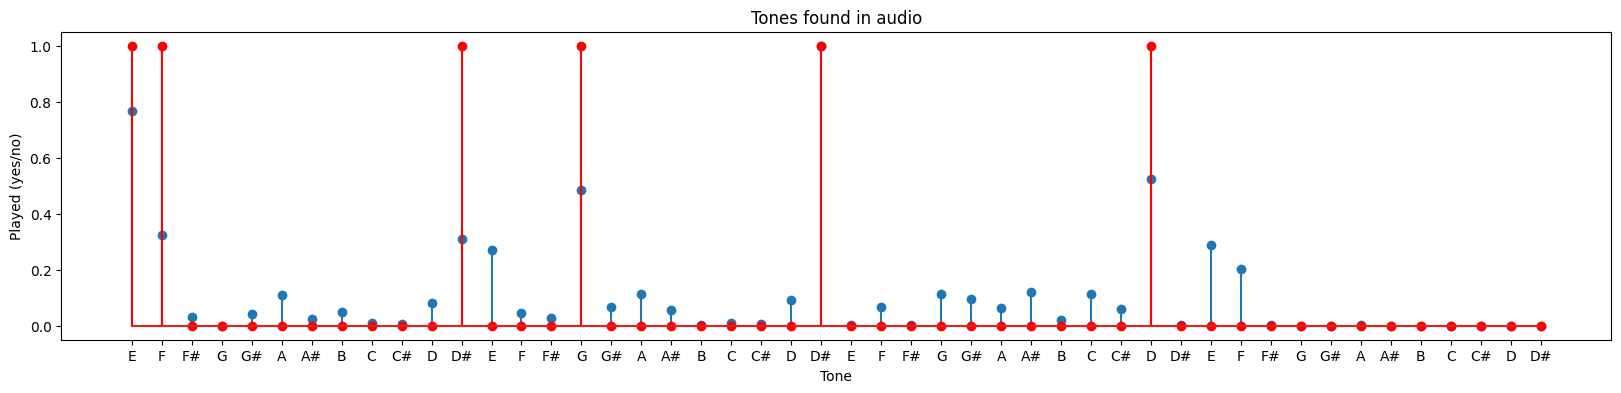

In [97]:
# find tones from audio file
B = np.load('B.npy')
a,b = audio2tones('gnote.wav', B, 6)

plt.figure(figsize=(20,4))
plt.stem(b)
plt.stem(a,'r')
plt.xlabel('Tone')
plt.ylabel('Played (yes/no)')
plt.title('Tones found in audio')
plt.xticks(range(len(a)),tones)
plt.show()

In [102]:
# find tab from tones
tones,raw = audio2tones('gnote.wav', B, 6, tokenize=True)
tones2tab(tones)

<ipython-input-95-fa17d3b7b064>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_data = read(file_name)


[11, 10, -1, 8, -1, -1]

In [103]:
# find chord from tones
tones,raw = audio2tones('gnote.wav', B, 3, tokenize=True)
tones2chord(tones)

<ipython-input-95-fa17d3b7b064>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_data = read(file_name)


['Am']